# Variance-level plots

### Classes and modules

In [1]:
#Lets have matplotlib "inline"
%matplotlib inline

import os
import sys

#Import packages we need
import numpy as np
import datetime
from IPython.display import display
import copy

#For plotting
import matplotlib
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

plt.style.use('dark_background')

plt.rcParams["image.origin"] = "lower"

import pycuda.driver as cuda

GPU Ocean-modules:

In [2]:
from gpuocean.utils import IPythonMagic, Common

In [3]:
%cuda_context_handler gpu_ctx

In [4]:
ls = [6, 7, 8]

In [5]:
from gpuocean.utils import DoubleJetCase

args_list = []
init_list = []

for l in ls:
    doubleJetCase = DoubleJetCase.DoubleJetCase(gpu_ctx, DoubleJetCase.DoubleJetPerturbationType.SteadyState, ny=2**l, nx=2**(l+1))
    doubleJetCase_args, doubleJetCase_init, _ = doubleJetCase.getInitConditions()

    args_list.append(doubleJetCase_args)
    init_list.append(doubleJetCase_init)

In [6]:
Ts = [3*24*3600, 4*24*3600, 5*24*3600, 6*24*3600, 7*24*3600, 8*24*3600, 9*24*3600, 10*24*3600]

In [7]:
source_path = "/home/florianb/havvarsel/multilevelDA/doublejet/scripts/VarianceLevelMC/2023-09-20T17_04_27"
# source_path = "/home/florianb/havvarsel/multilevelDA/doublejet/scripts/VarianceLevelMC/2023-09-20T17_04_27mean"

In [8]:
vars_file_list = []
for f in os.listdir(source_path):
    if f.startswith("vars") and f.endswith(".npy"):
        vars_file_list.append(f)
vars_file_list.sort()

diff_vars_file_list = []
for f in os.listdir(source_path):
    if f.startswith("diff_vars") and f.endswith(".npy"):
        diff_vars_file_list.append(f)
diff_vars_file_list.sort()

In [9]:
vars_list = [np.load(os.path.join(source_path,vars_file)) for vars_file in vars_file_list]
diff_vars_list = [np.load(os.path.join(source_path,diff_vars_file)) for diff_vars_file in diff_vars_file_list]

In [10]:
import matplotlib.lines as mlines
from matplotlib.legend_handler import HandlerTuple

def plotLvlVarTs(relative=False):
    
    # Plot
    # with plt.rc_context({'lines.color':'black', 
    #                 'text.color':'black', 
    #                 'axes.labelcolor':'black', 
    #                 'xtick.color':'black',
    #                 'ytick.color':'black'}):

    fig, axs = plt.subplots(1,3, figsize=(25,5))
    fig.suptitle("Variance level plot")

    axs[0].set_title("$\eta$", fontsize=15)
    axs[1].set_title("$hu$", fontsize=15)
    axs[2].set_title("$hv$", fontsize=15)

    Nxs = [nx*ny for nx, ny in zip([da["nx"] for da in args_list], [da["ny"] for da in args_list])]

    for T_idx in range(len(vars_list)):
        vars = np.array(vars_list[T_idx])
        diff_vars = np.array(diff_vars_list[T_idx])

        if relative:
            diff_vars = diff_vars/vars[-1]
            vars = vars/vars[-1]
            axs[0].set_ylim((None,2))
            axs[1].set_ylim((None,2))
            axs[2].set_ylim((None,2))

        for i in range(3):


            axs[i].loglog(Nxs, vars[:,i], linewidth=3, c="C0", alpha=0.1+0.9*T_idx/len(vars_list))
            axs[i].loglog(Nxs[1:], diff_vars[:,i], linewidth=3, c="C1", alpha=0.1+0.9*T_idx/len(vars_list))
            
    handles_var = [mlines.Line2D([], [], c="C0", lw=3, label="$|| Var[u^l] ||_{L^2}$"), 
                    mlines.Line2D([], [], c="C1", lw=3, label="$|| Var[u^l-u^{l-1}] ||_{L^2}$")]
    legend_var = axs[0].legend(handles=handles_var, title="Variances",  loc=(0.01,0.7), fontsize=12)
    axs[0].add_artist(legend_var)
            
    handles_T = [(mlines.Line2D([], [], c="C0", alpha=0.1+0.9*T_idx/len(vars_list), lw=3, label=str(Ts[T_idx])), 
                  mlines.Line2D([], [], c="C1", alpha=0.1+0.9*T_idx/len(vars_list), lw=3, label=str(Ts[T_idx])))
                   for T_idx in range(len(vars_list))]
    legend_T = axs[0].legend(handles_T, [str(T/(3600*24)) for T in Ts], title="Time [day]", fontsize=12, 
                                loc=(0.01,0.01),  handler_map={tuple: HandlerTuple(ndivide=None)})
    
    for i in range(3):
        axs[i].set_xlabel("# grid cells", fontsize=15)
        axs[i].set_xticks(Nxs)
        axs[i].xaxis.grid(True)

    # legend_var.get_title()t_c.set_color('black')
    # legend_T.get_title().seolor('black')

    for i in range(3):
        axs[i].set_xlim((2000, max(Nxs)))

    if not relative:
        axs[0].set_ylim((1e2,1e7))
        axs[1].set_ylim((1e7,1e11))
        axs[2].set_ylim((1e7,1e12))

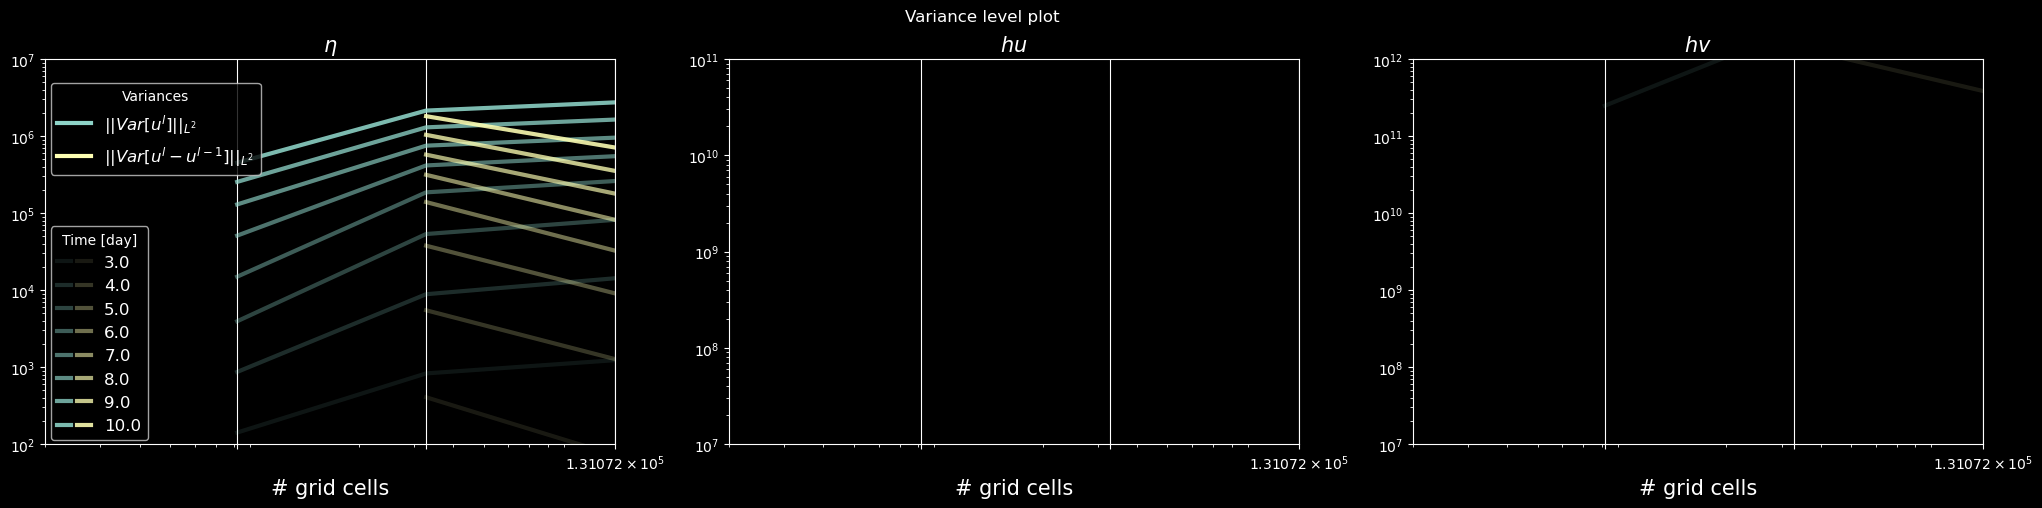

In [11]:
plotLvlVarTs()

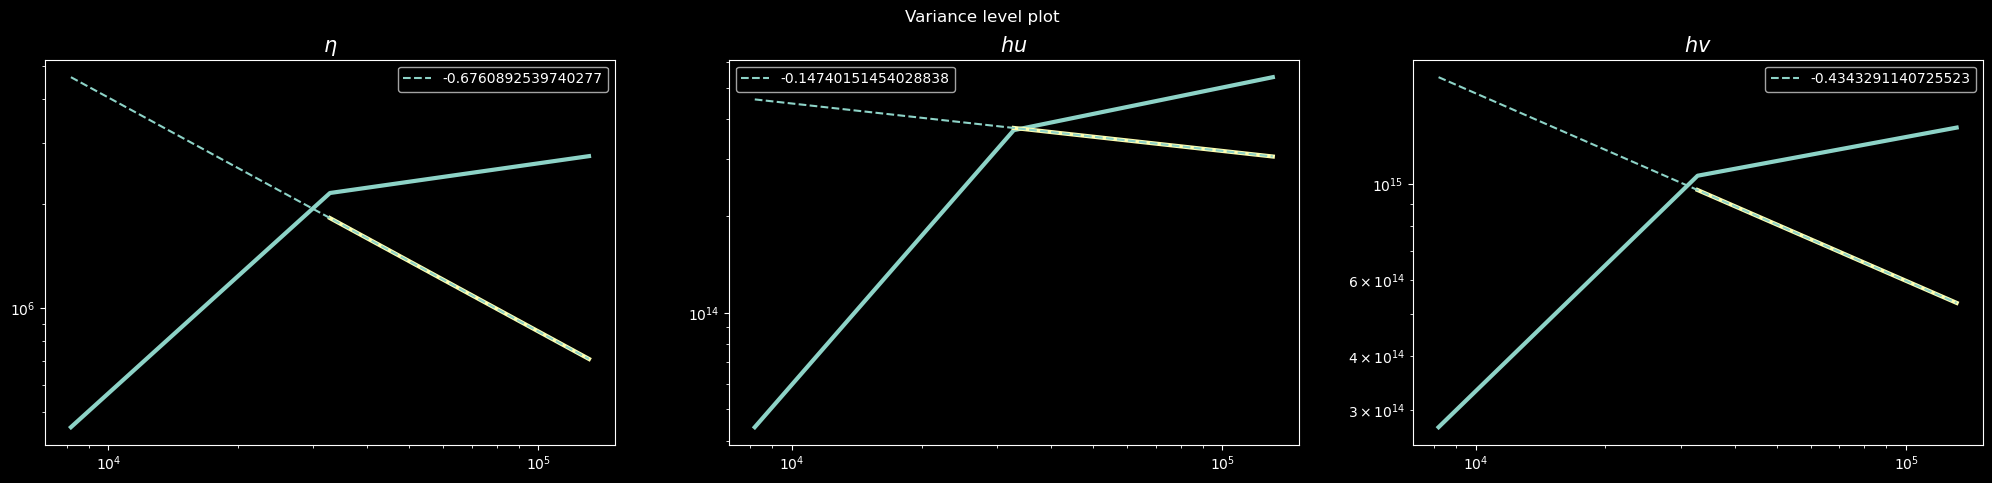

In [12]:
fig, axs = plt.subplots(1,3, figsize=(25,5))
fig.suptitle("Variance level plot")

axs[0].set_title("$\eta$", fontsize=15)
axs[1].set_title("$hu$", fontsize=15)
axs[2].set_title("$hv$", fontsize=15)

Nxs = [nx*ny for nx, ny in zip([da["nx"] for da in args_list], [da["ny"] for da in args_list])]

vars = np.array(vars_list[-1])
diff_vars = np.array(diff_vars_list[-1])

for i in range(3):
    axs[i].loglog(Nxs, vars[:,i], linewidth=3, c="C0")
    axs[i].loglog(Nxs[1:], diff_vars[:,i], linewidth=3, c="C1")

    poly = np.polyfit(np.log(Nxs[1:]), np.log(diff_vars[:,i]), 1)
    axs[i].loglog(Nxs, np.exp(poly[1])*Nxs**poly[0], '--', label=str(poly[0]))
    axs[i].legend()

/home/florianb/miniforge3/envs/gpuocean/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
/home/florianb/miniforge3/envs/gpuocean/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
/home/florianb/miniforge3/envs/gpuocean/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.


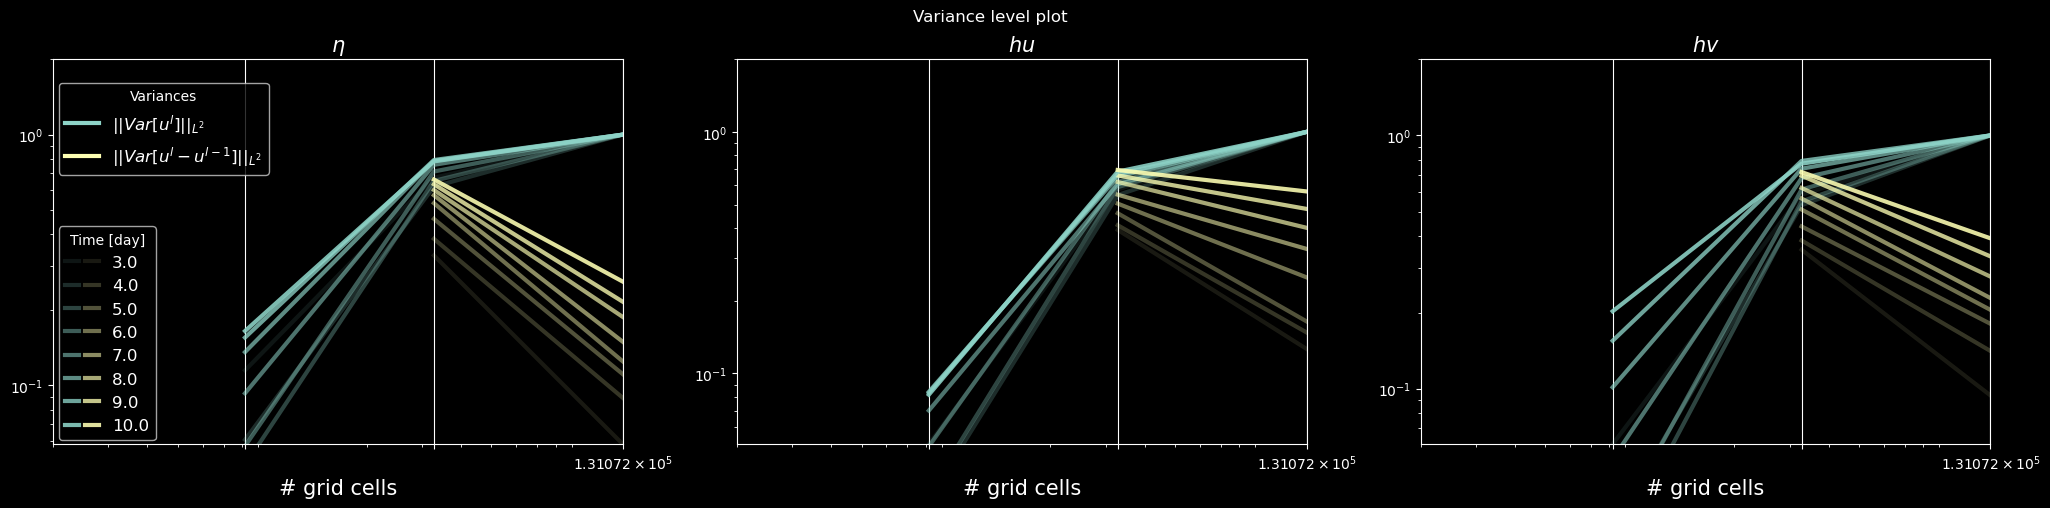

In [13]:
plotLvlVarTs(relative=True)

In [14]:
STOP

Exception caught: Resetting to CUDA context gpu_ctx
Traceback (most recent call last):
  File "/home/florianb/miniforge3/envs/gpuocean/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3552, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_1604645/2165152129.py", line 1, in <module>
    STOP
NameError: name 'STOP' is not defined


NameError: name 'STOP' is not defined

In [ ]:
for t_idx, T in enumerate(Ts):
    varsT = [vars_listTs[t_idx][l_idx] for l_idx in range(len(ls))]
    np.save(source_path+"/vars_"+str(T), np.array(varsT))

    diff_varsT = [diff_vars_listTs[t_idx][l_idx] for l_idx in range(len(ls)-1)]
    np.save(source_path+"/diff_vars_"+str(T), np.array(diff_varsT))

    center_varsT = [center_vars_listTs[t_idx][l_idx] for l_idx in range(len(ls))]
    np.save(source_path+"/center_vars_"+str(T), np.array(center_varsT))

    center_diff_varsT = [center_diff_vars_listTs[t_idx][l_idx] for l_idx in range(len(ls)-1)]
    np.save(source_path+"/center_diff_vars_"+str(T), np.array(center_diff_varsT))

In [ ]:
Nxs = np.array([nx*ny for nx, ny in zip([da["nx"] for da in grid_args_list], [da["ny"] for da in grid_args_list])])

In [ ]:
center_vars_file = np.array(center_vars_listTs)[0]
for l_idx in range(1,len(ls)):
    center_vars_file = np.c_[center_vars_file, np.array(center_vars_listTs)[l_idx]]

In [ ]:
center_diff_vars_file = np.array(center_diff_vars_listTs)[0]
for l_idx in range(1,len(ls)):
    center_diff_vars_file = np.c_[center_diff_vars_file, np.array(center_diff_vars_listTs)[l_idx]]

In [ ]:
np.savetxt(source_path+"/center_vars.txt", np.c_[Nxs, center_vars_file],
           delimiter=",", fmt="%9.9f")

np.savetxt(source_path+"/center_diff_vars.txt", np.c_[Nxs[1:], center_diff_vars_file],
           delimiter=",", fmt="%9.9f")